# Foodies Shop feature extraction 

---

In this notebook we try to extract data from table `shop`

In [252]:
%matplotlib inline
from utils import read_csv
import pandas as pd

In [253]:
shop = read_csv("shop")

In [254]:
shop.head()

,id,logo,cover,name,branch,description,tel,website,line,facebook,...,has_carpark,landmark,worktime,last_order,holiday,status,created_on,created_by,updated_on,updated_by
0,1,NaN,NaN,Akimitsu Tendon Rayong (อาคิมิซุ),NaN,NaN,038017585,NaN,NaN,https://www.facebook.com/akimitsurayong/,...,F,NaN,"[{""day"": ""จันทร์"", ""checked"": true, ""time"": [{...",0,NaN,Y,0000-00-00 00:00:00,0,2019-06-05 17:21:50,0
1,2,NaN,NaN,โอชิเน พิษณุโลก,NaN,NaN,"055001324, 0932172828",NaN,http://line.naver.jp/ti/p/oshineiphitsanulok,https://m.facebook.com/OshineiPhitsanulok/,...,F,NaN,"[{""day"": ""จันทร์"", ""checked"": true, ""time"": [{...",0,NaN,Y,0000-00-00 00:00:00,0,2019-06-05 17:21:50,0
2,3,NaN,NaN,Isao (อิซาโอะ),NaN,NaN,"0956614564,0941981942,022580645",https://www.isaotaste.com/,http://line.naver.jp/ti/p/@isaobkk,https://www.facebook.com/isaobkk,...,F,NaN,"[{""day"": ""จันทร์"", ""checked"": true, ""time"": [{...",0,NaN,Y,0000-00-00 00:00:00,0,2019-06-05 17:21:50,0
3,4,NaN,NaN,Sushi Mori (ซูชิ โมริ) Sathorn Square,NaN,NaN,092-424-4040,NaN,http://line.naver.jp/ti/p/@aax7413r,NaN,...,F,NaN,"[{""day"": ""จันทร์"", ""checked"": true, ""time"": [{...",0,NaN,Y,0000-00-00 00:00:00,0,2019-06-05 17:21:50,0
4,5,NaN,NaN,Bankara Ramen (บังคาระ ราเมง) สุขุมวิท 39,NaN,NaN,"02-662-5162,02-662-5161",https://www.facebook.com/pages/Bankara-Ramen/1...,NaN,https://www.facebook.com/BankaraRamen?fref=ts,...,F,NaN,"[{""day"": ""จันทร์"", ""checked"": true, ""time"": [{...",0,NaN,Y,0000-00-00 00:00:00,0,2019-06-05 17:21:50,0


## Clean mock

In [255]:
def clean_mock(df):
    df = df[df["name"]!="Shop Name"]
    df = df[df["shop_price_from"]!=0]
    return df

In [256]:
print("Before clean", shop.shape)
shop = clean_mock(shop)
print("After", shop.shape)

Before clean (65040, 34)
After (61478, 34)


## Telephone count

In [257]:
shop['tel_count'] = shop.tel.dropna().apply(lambda x: len(x.split(","))).fillna(0)
shop['tel_count'].value_counts().sort_values()

5.0        1
4.0      154
3.0     1527
2.0     8249
1.0    28747
Name: tel_count, dtype: int64

## Means of contact

In [258]:
def clean_feature(col, condition, default = False):
    return col.apply(lambda x: condition(x) if(not pd.isnull(x)) else x).fillna(default)

shop['has_website'] = clean_feature(shop['website'], lambda x: x.find("http") == 0)
shop['has_line'] = clean_feature(shop['line'], lambda x: len(x) > 0).fillna(0)
shop['has_facebook'] = clean_feature(shop['facebook'], lambda x: len(x) > 0).fillna(0)
shop['has_instagram'] = clean_feature(shop['instagram'], lambda x: len(x) > 0).fillna(0)
shop['has_all'] = shop['has_website'] & shop['has_line'] & shop['has_facebook'] & shop['has_instagram']

## Work time

In [259]:
def clean_worktime(s):
    stop_word = ["true", "false"]
    for x in stop_word:
        s = s.replace(x, "\"" + x + "\"")
    return s
    

shop['open_period_count'] = shop.worktime.fillna("[]").apply(clean_worktime).apply(eval).apply(len)

## Price

In [260]:
shop[['shop_price_from', 'shop_price_to']].head()

,shop_price_from,shop_price_to
0,101,250
1,251,500
2,251,500
3,1000,3000
4,251,500


In [261]:
import numpy as np
shop['shop_price'] = shop.shop_price_from.apply(str) + "-" + shop.shop_price_to.apply(str)
shop['shop_average_price'] = ((shop.shop_price_from + shop.shop_price_to) / 2) + 1 # Hack for log
shop['shop_average_log_price'] = np.log(shop.shop_average_price)

## Is shop in popular location

In [262]:
from sklearn.cluster import KMeans

In [263]:
positions = shop[['lat','lng']].dropna()

In [264]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(positions)

In [266]:
shop['kmeans'] = kmeans.predict(shop[['lat','lng']].fillna(0))

count_map = shop['kmeans'].value_counts().to_dict()
shop['near_shop_counts'] = shop['kmeans'].apply(lambda x: count_map[x])
shop['near_shop_counts_log'] = np.log(shop['near_shop_counts'])

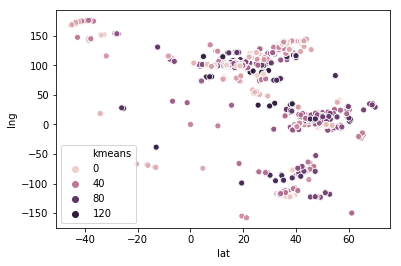

In [267]:
# How it would look like.
import seaborn as sb
sb.scatterplot(shop.lat, shop.lng,hue =shop.kmeans)

## Carpar

In [268]:
shop['has_carpark_i'] = shop['has_carpark'].apply(lambda x: x!="F")

## Description NLP

--- 

has lot of potential. For now going to just use the length of description

In [269]:
shop['description_length'] = shop.description.fillna("").apply(len)

## Collecting all features

In [270]:
features = [
    "tel_count",
    'has_website',
    'has_line',
    'has_facebook',
    'has_instagram',
    'has_all',
    'has_carpark_i', # has = better
    'open_period_count',
    'near_shop_counts_log',
    "description_length",
    'shop_average_log_price',
]

selected_features = shop[features].fillna(0)

In [271]:
selected_features.head()

,tel_count,has_website,has_line,has_facebook,has_instagram,has_all,has_carpark_i,open_period_count,near_shop_counts_log,description_length,shop_average_log_price
0,1.0,False,False,True,False,False,False,7,8.910856,0,5.173321
1,2.0,False,True,True,False,False,False,7,7.349874,0,5.930918
2,3.0,True,True,True,True,True,False,7,9.867860,0,5.930918
3,1.0,False,True,False,True,False,False,4,9.867860,0,7.601402
4,2.0,True,False,True,False,False,False,7,8.910856,0,5.930918


### Convert boolean col to number

In [272]:
bool_columns = [col for col in selected_features.columns if "has" in col]
selected_features[bool_columns] = selected_features[bool_columns].astype(int)

In [273]:
selected_features.head()

,tel_count,has_website,has_line,has_facebook,has_instagram,has_all,has_carpark_i,open_period_count,near_shop_counts_log,description_length,shop_average_log_price
0,1.0,0,0,1,0,0,0,7,8.910856,0,5.173321
1,2.0,0,1,1,0,0,0,7,7.349874,0,5.930918
2,3.0,1,1,1,1,1,0,7,9.867860,0,5.930918
3,1.0,0,1,0,1,0,0,4,9.867860,0,7.601402
4,2.0,1,0,1,0,0,0,7,8.910856,0,5.930918


# Explore

---

Let's set weight for each feature and see which will go on top

The intuition here is that we have no response/target for our data, then we can
inituitively regression the linear regression model by ourselves. This is a very naive but
good start for manually tuning the model and see difference result.

In [309]:
feature_names = selected_features.columns
first_weight =  {
     'tel_count': 0.3,
     'has_website': 0.8,
     'has_line': 0.6,
     'has_facebook':0.4,
     'has_instagram': 0.7,
     'has_all': 0.3,
     'has_carpark_i':0.9,
     'open_period_count': 0.2,
     'shop_average_log_price': -0.75,
     'near_shop_counts_log': 0.03,
     'description_length': 0.05
}

In [313]:
def apply_score(weights):
    def f(row):
        return [row[weight]*weights[weight] for weight in weights]
    return f
scores_summary = selected_features.apply(apply_score(first_weight), axis=1)
selected_features['scores_breakdown'] = scores_summary
selected_features['scores'] = scores_summary.apply(sum)

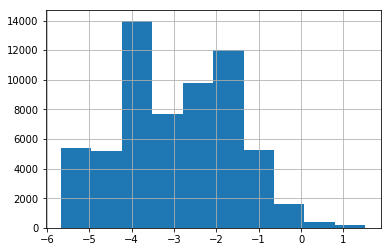

In [316]:
selected_features['scores'].hist()

In [317]:
shop_with_scores = shop.set_index("id").merge(sorted_shop,left_index=True, right_index=True).sort_values("scores", ascending=False)
shop_with_scores[['name','description', 'website','shop_price','near_shop_counts','scores']].head(10)

,name,description,website,shop_price,near_shop_counts,scores
61292,Beach Tango Koh Chang,NaN,http://beachtangorestaurantkohchang.business.s...,101-250,7412,3.416721
35132,Hua Kee Chicken Rice,NaN,NaN,101-250,1222,3.332441
44437,"Changla Cafeteria Ladakh, India",NaN,NaN,100-3000,31,3.332441
61136,บะหมี่เกี๊ยวเลียบคลองสอง (บะหมี่เกี๊ยวหมูแดงเล...,NaN,NaN,100-3000,19300,3.232441
53924,Jamie's Italian Perth,NaN,NaN,501-1000,17,3.097199
60973,Hofburg,NaN,NaN,501-1000,59,3.097199
37293,ทองคำเลือดหมู,NaN,NaN,100-3000,1433,3.097199
64542,สเต็กออนลี่,NaN,NaN,101-250,1860,2.997199
54064,O-OH Farm ฉลอง ฉลอง,NaN,NaN,101-250,2028,2.836616
37570,Praise House Comgee and Noodle cuisine,NaN,NaN,251-500,661,2.797199


### What if we want to emphasize more expensive shop in the front page

---

Easy, just reset the weight.

Instead of penalizing expensive shop, we want to encourage the price instead by this ser of new weight


In [318]:
weights_more_expensive =  {
     'tel_count': 0.3,
     'has_website': 0.8,
     'has_line': 0.6,
     'has_facebook':0.4,
     'has_instagram': 0.7,
     'has_all': 0.3,
     'has_carpark_i':0.9,
     'open_period_count': 0.2,
     'shop_average_log_price': 2.75,
     'near_shop_counts_log': 0.03,
     'description_length': 0.05
}

In [ ]:
selected_features['scores'] = selected_features.apply(apply_score(weights_more_expensive), axis=1)
selected_features['scores'].hist()

In [ ]:
shop_with_scores = shop.set_index("id").merge(sorted_shop,left_index=True, right_index=True).sort_values("scores", ascending=False)
shop_with_scores[['name','description', 'website','shop_price','near_shop_counts','scores']].head(10)